In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from textblob import TextBlob
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, xgboost, numpy, textblob, string
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import train_test_split

from warnings import filterwarnings
filterwarnings('ignore')


Bad key "text.kerning_factor" on line 4 in
C:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:

train  =pd.read_csv("train.csv")

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
#Dropping unncessary columns
train.drop(["keyword","location"],axis = 1,inplace = True)


# Cleaning  & Preprocessing

In [7]:
train["text"] = train["text"].apply(lambda x : " ".join(x.lower() for x in x.split()))

In [8]:
train.head()

,id,text,target
0,1,our deeds are the reason of this #earthquake m...,1
1,4,forest fire near la ronge sask. canada,1
2,5,all residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,just got sent this photo from ruby #alaska as ...,1


## Dropping Numbers

In [9]:
train["text"] = train["text"].str.replace("\d","")

In [10]:
train.head()

,id,text,target
0,1,our deeds are the reason of this #earthquake m...,1
1,4,forest fire near la ronge sask. canada,1
2,5,all residents asked to 'shelter in place' are ...,1
3,6,", people receive #wildfires evacuation orders ...",1
4,7,just got sent this photo from ruby #alaska as ...,1


## Dropping punctuation marks

In [11]:
train["text"] = train["text"].str.replace("[^\w\s]","")

In [12]:
train.head()

,id,text,target
0,1,our deeds are the reason of this earthquake ma...,1
1,4,forest fire near la ronge sask canada,1
2,5,all residents asked to shelter in place are be...,1
3,6,people receive wildfires evacuation orders in...,1
4,7,just got sent this photo from ruby alaska as s...,1


In [13]:
import nltk 

In [14]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TOLGA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Stopwords

**Stopwords** : Words that are filtered out by Web search engines and other enterprise searching and indexing platforms. Stop words are natural language words which have very little meaning, such as "and", "the", "a", "an", and similar words.

In [15]:
from nltk.corpus import stopwords
sw = stopwords.words("english")

In [16]:
sw.append("u")
sw.append("im")

In [17]:
train["text"] = train["text"].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

## Lemmatization

**Lemmatization :** In linguistics, it is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item. Putting an example to the definition, “computers” is an inflected form of “computer”, the same logic as “dogs” being an inflected form of “dog”.

In [18]:
from textblob import Word
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\TOLGA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
train["text"] = train["text"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [20]:
train.head()

,id,text,target
0,1,deed reason earthquake may allah forgive u,1
1,4,forest fire near la ronge sask canada,1
2,5,resident asked shelter place notified officer ...,1
3,6,people receive wildfire evacuation order calif...,1
4,7,got sent photo ruby alaska smoke wildfire pour...,1


In [21]:
#regex
train["text"] = train["text"].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',"")
train["text"] = train["text"].str.replace(r"We're", "We are")
train["text"] = train["text"].str.replace(r"That's", "That is")
train["text"] = train["text"].str.replace(r"won't", "will not")
train["text"] = train["text"].str.replace(r"they're", "they are")
train["text"] = train["text"].str.replace(r"Can't", "Cannot")
train["text"] = train["text"].str.replace(r"wasn't", "was not")
train["text"] = train["text"].str.replace(r"don\x89Ûªt", "do not")
train["text"] = train["text"].str.replace(r"aren't", "are not")
train["text"] = train["text"].str.replace(r"isn't", "is not")
train["text"] = train["text"].str.replace(r"You're", "You are")
train["text"] = train["text"].str.replace(r"I'M", "I am")
train["text"] = train["text"].str.replace(r"shouldn't", "should not")
train["text"] = train["text"].str.replace(r"wouldn't", "would not")
train["text"] = train["text"].str.replace(r"i'm", "I am")
train["text"] = train["text"].str.replace(r"We've", "We have")
train["text"] = train["text"].str.replace(r"Didn't", "Did not")
train["text"] = train["text"].str.replace(r"it's", "it is")
train["text"] = train["text"].str.replace(r"can't", "cannot")
train["text"] = train["text"].str.replace(r"don't", "do not")
train["text"] = train["text"].str.replace(r"you're", "you are")
train["text"] = train["text"].str.replace(r"I've", "I have")
train["text"] = train["text"].str.replace(r"Don't", "do not")
train["text"] = train["text"].str.replace(r"I'll", "I will")
train["text"] = train["text"].str.replace(r"Let's", "Let us")
train["text"] = train["text"].str.replace(r"Could've", "Could have")
train["text"] = train["text"].str.replace(r"youve", "you have")
train["text"] = train["text"].str.replace(r"It's", "It is")

In [22]:
from sklearn.model_selection import train_test_split

## Visualisation

In [23]:
freq = (train["text"][0:1000]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()

In [24]:
freq.columns = ["words","tf"]

In [25]:
x = freq[freq["tf"] > 30].sort_values(by = "tf" ,ascending = False)

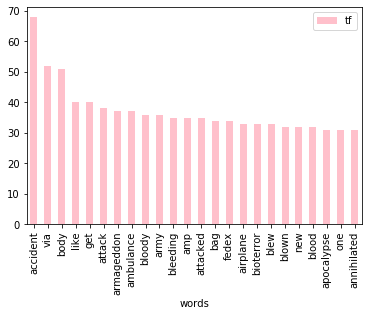

In [26]:
x.plot.bar(x = "words", y = "tf",color = "pink");

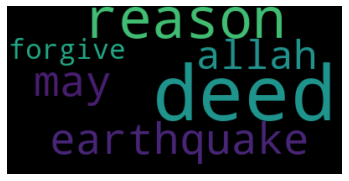

***********************************************


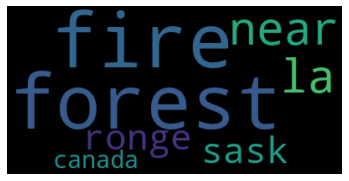

***********************************************


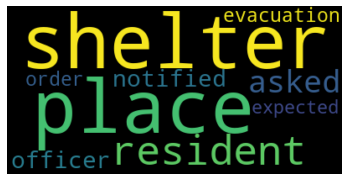

***********************************************


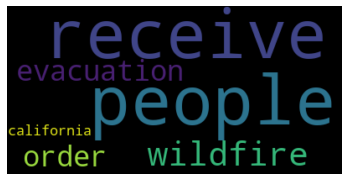

***********************************************


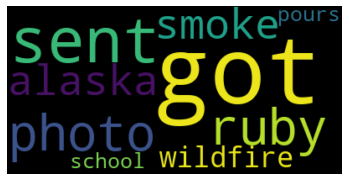

***********************************************


In [27]:
#WordCloud for the first 5 row
for i in range (0,5):
    text = train["text"][i]
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud, interpolation = "bilinear")
    plt.axis("off")
    plt.show()
    print("***********************************************")

In [31]:
from nltk.tokenize import sent_tokenize, word_tokenize 
import warnings 
  
warnings.filterwarnings(action = 'ignore') 
  

In [32]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [33]:
x_train, x_test, y_train, y_test = train_test_split(train["text"], train["target"],
                                                    test_size = 0.3,
                                                    random_state = 18)

# Prediction

## Count Vector


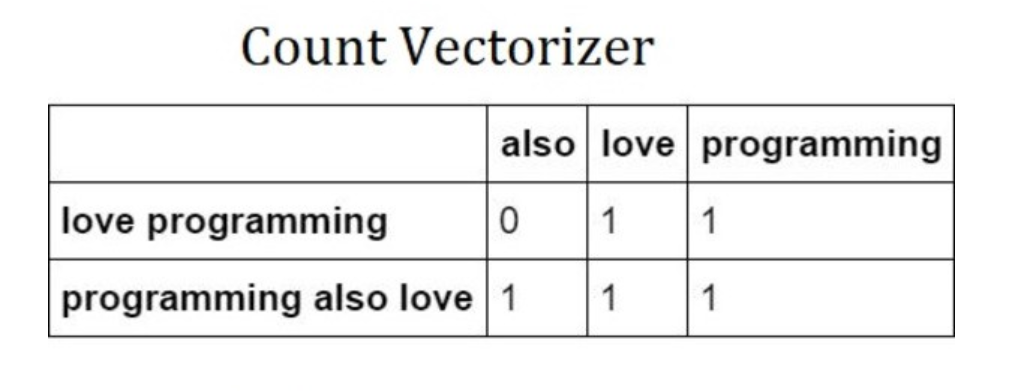

By word frequency we indicate the number of times each token occurs in a text. When talking about word frequency, we distinguish between types and tokens. Types are the distinct words in a corpus, whereas tokens are the words, including repeats. Let's see how this works in practice.

In [34]:
vectorizer = CountVectorizer()
vectorizer.fit(x_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [35]:
x_train_count = vectorizer.transform(x_train)
x_test_count = vectorizer.transform(x_test)

## Logistic Regression

In [36]:
loj = linear_model.LogisticRegression()
loj_model = loj.fit(x_train_count, y_train)
y_pred = loj_model.predict(x_test_count)


accuracy_score(y_test,y_pred)

0.7802101576182137

## Naive Bayes

In [37]:
x_train_count

<5329x15808 sparse matrix of type '<class 'numpy.int64'>'
	with 50222 stored elements in Compressed Sparse Row format>

In [38]:
nb = naive_bayes.MultinomialNB()
nb_model = nb.fit(x_train_count,y_train)
y_pred = nb_model.predict(x_test_count)
accuracy_score(y_test,y_pred)

0.7950963222416813

## RF

In [39]:
rf = ensemble.RandomForestClassifier()
rf_model = rf.fit(x_train_count,y_train)
y_pred = rf_model.predict(x_test_count)
accuracy_score(y_test,y_pred)

0.7648861646234676

## XGBOOST

In [40]:
xgb = xgboost.XGBClassifier()
xgb_model = xgb.fit(x_train_count,y_train)
y_pred = xgb_model.predict(x_test_count)
accuracy_score(y_test,y_pred)

0.7657618213660246

## TF-IDF Word Level

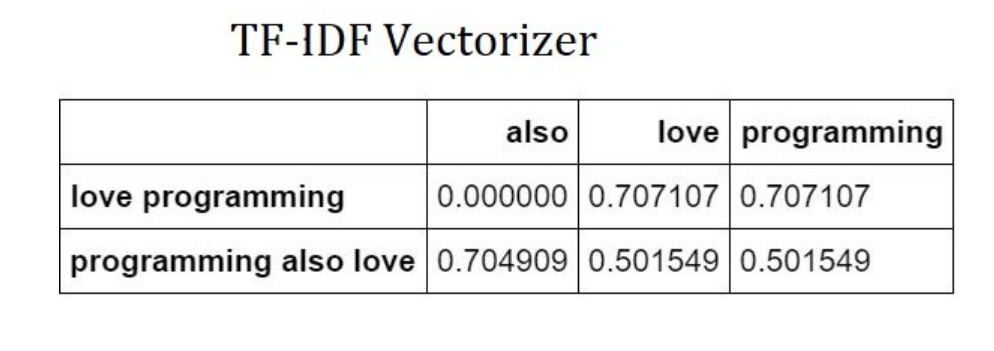



**Term-frequency-inverse document frequency (TF-IDF)** is another way to judge the topic of an article by the words it contains. With TF-IDF, words are given weight – TF-IDF measures relevance, not frequency. That is, wordcounts are replaced with TF-IDF scores across the whole dataset.




In [41]:
tf_idf_word_vectorizer = TfidfVectorizer()

tf_idf_word_vectorizer.fit(x_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [42]:
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(x_train)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(x_test)

## Logistic Regression

In [43]:
loj = linear_model.LogisticRegression()
loj_model = loj.fit(x_train_tf_idf_word, y_train)
y_pred = loj_model.predict(x_test_tf_idf_word)
accuracy_score(y_test,y_pred)

0.7915936952714536

## Naive Bayes

In [44]:
nb = naive_bayes.MultinomialNB()
nb_model = nb.fit(x_train_tf_idf_word,y_train)
y_pred = nb.predict(x_test_tf_idf_word)
accuracy_score(y_test,y_pred)

0.7946584938704028

## For the test


In [45]:
test = pd.read_csv("test.csv")
test.drop(["keyword","location"],axis = 1,inplace = True)

In [46]:
def prep(test):
    
    
    test["text"] = test["text"].apply(lambda x : " ".join(x.lower() for x in x.split()))
    
    test["text"] = test["text"].str.replace("\d","")
    
    test["text"] = test["text"].str.replace("[^\w\s]","")
    
    test["text"] = test["text"].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
    
    test["text"] = test["text"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    
    test["text"] = test["text"].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',"")
    
    test["text"] = test["text"].str.replace(r'(((http)(s)?|www(.)?)(://)?\S+)',"")
    
    test["text"] = test["text"].str.replace(r"\x89ÛÓ", "")
    test["text"] = test["text"].str.replace(r"he's", "he is")
    test["text"] = test["text"].str.replace(r"there's", "there is")
    test["text"] = test["text"].str.replace(r"We're", "We are")
    test["text"] = test["text"].str.replace(r"That's", "That is")
    test["text"] = test["text"].str.replace(r"won't", "will not")
    test["text"] = test["text"].str.replace(r"they're", "they are")
    test["text"] = test["text"].str.replace(r"Can't", "Cannot")
    test["text"] = test["text"].str.replace(r"wasn't", "was not")
    test["text"] = test["text"].str.replace(r"don\x89Ûªt", "do not")
    test["text"] = test["text"].str.replace(r"aren't", "are not")
    test["text"] = test["text"].str.replace(r"isn't", "is not")
    test["text"] = test["text"].str.replace(r"You're", "You are")
    test["text"] = test["text"].str.replace(r"I'M", "I am")
    test["text"] = test["text"].str.replace(r"shouldn't", "should not")
    test["text"] = test["text"].str.replace(r"wouldn't", "would not")
    test["text"] = test["text"].str.replace(r"i'm", "I am")
    test["text"] = test["text"].str.replace(r"We've", "We have")
    test["text"] = test["text"].str.replace(r"Didn't", "Did not")
    test["text"] = test["text"].str.replace(r"it's", "it is")
    test["text"] = test["text"].str.replace(r"can't", "cannot")
    test["text"] = test["text"].str.replace(r"don't", "do not")
    test["text"] = test["text"].str.replace(r"you're", "you are")
    test["text"] = test["text"].str.replace(r"I've", "I have")
    test["text"] = test["text"].str.replace(r"Don't", "do not")
    test["text"] = test["text"].str.replace(r"I'll", "I will")
    test["text"] = test["text"].str.replace(r"Let's", "Let us")
    test["text"] = test["text"].str.replace(r"Could've", "Could have")
    test["text"] = test["text"].str.replace(r"youve", "you have")
    test["text"] = test["text"].str.replace(r"It's", "It is")
    

    
    return test
  



In [47]:
df = prep(test)


In [48]:
test_x = df["text"]

In [49]:
vectorizer = CountVectorizer()
vectorizer.fit(test_x)
vectorizer.transform(test_x)

<3263x9357 sparse matrix of type '<class 'numpy.int64'>'
	with 29029 stored elements in Compressed Sparse Row format>

In [50]:
 vectorizer.transform(test_x)

<3263x9357 sparse matrix of type '<class 'numpy.int64'>'
	with 29029 stored elements in Compressed Sparse Row format>

In [51]:
x_test_co= vectorizer.transform(test_x)

In [52]:
x_train_count = vectorizer.transform(x_train)

In [53]:
nb = naive_bayes.MultinomialNB()
nb_model = nb.fit(x_train_count,y_train)
y_pred = nb_model.predict(x_test_co)
y_pred

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [54]:
dictt = {}
dictt['id'] = test.id
dictt['target'] = y_pred
submission = pd.DataFrame(dictt)

In [55]:
submission

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [56]:
#submission.to_csv("submission3.csv" , index = None)

# Credits


https://www.webopedia.com/TERM/S/stop_words.html

https://www.twinword.com/blog/what-is-lemmatization/

https://port.sas.ac.uk/mod/book/view.php?id=583&chapterid=381#:~:text=2.3%20Word%20count,-After%20tokenising%20a&text=By%20word%20frequency%20we%20indicate,how%20this%20works%20in%20practice.

https://wiki.pathmind.com/bagofwords-tf-idf

https://medium.com/deep-math-machine-learning-ai/chapter-9-1-nlp-word-vectors-d51bff9628c1